In [56]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import csv
import re
import pickle
import time
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torch.nn.utils import clip_grad_norm_

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from wordcloud import WordCloud,STOPWORDS
from matplotlib_venn import venn3, venn3_circles

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [6]:
data_path = "/content/drive/MyDrive/SMAI_Project/train.csv"
df = pd.read_csv(data_path)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df['good'] = 1
df.loc[df[LABEL_COLUMNS].sum(axis=1) != 0, 'good'] = 0

In [13]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,good
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [22]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,good
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# start EDA from here

In [23]:
# sample comment for each category
for i in ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate','good']:
    print("{} :".format(i.upper()))
    print(df.loc[df[i]==1, 'comment_text'].sample().values[0][:500], "\n")

TOXIC :
Wow you deleted my comment dumb ass 

SEVERE_TOXIC :
Fuck you you dumb sack of shit 

OBSCENE :
YOU'RE NO FUCKING METAL LORD DUMBASS YOU'RE A FAG FUCK YOU. 

THREAT :
, I hope your retarded kids get anal raped and murdered for having such a fag as a father. I'm gonna fuck your fat wife and trow her over the bridge. Consider yourself happy, another useful editor of Wikiepia retired. I see more users retired everyday. Don't even dare removing this you peace of shit, I do what ever the fuck I want with my talk page. Report all you want old cunt, I no longer give a fuck. And don't fucking leave a NPA warning template, just block me. That's what you do best. 

INSULT :
February 2012 (UTC)
No. you shut up, famousdog. You ARE a racist you vehemently refuse to accept the validity of a philosophical paradigm which is alien to the Western Scientific paradigm you're attached to. You will never have an accurate understanding of acupuncture if you are too xenophobic to adopt its endogenous 

In [24]:
# to find percentage of data vrs category
def category_percentage(df):
    # df['clean'] = np.where((df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']==0) & (df['insult']==0) & (df['identity_hate']==0), 1,0)
    
    categories = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'good']
    plot_data = df[categories].mean()*100

    plt.figure(figsize=(10,5))
    plt.title("percentage records by category")
    sns.barplot(x=plot_data.index, y = plot_data.values)
    plt.show()
    
    return

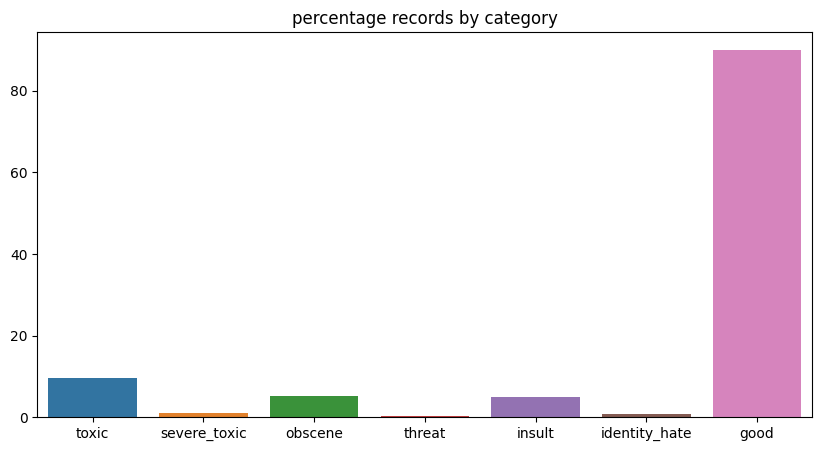

89.83% of the comments are clean i.e., non-toxic


In [26]:
category_percentage(df)
print("{}% of the comments are clean i.e., non-toxic".format(np.round(100*df['good'].sum()/df.shape[0],2)))
# perc_clean_data = np.round(100*df['good'].sum()/df.shape[0],2)

In [27]:
# correlation between the labels
def corr_between_labels(df):
    plt.figure(figsize=(15,8))
    plt.title("correlation between toxic categories")
    sns.heatmap(df.corr(),cmap='YlGnBu',annot=True) # Yellow-Green-Blue color palette
    plt.show()
    return 

<ipython-input-27-03bacef630db>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)


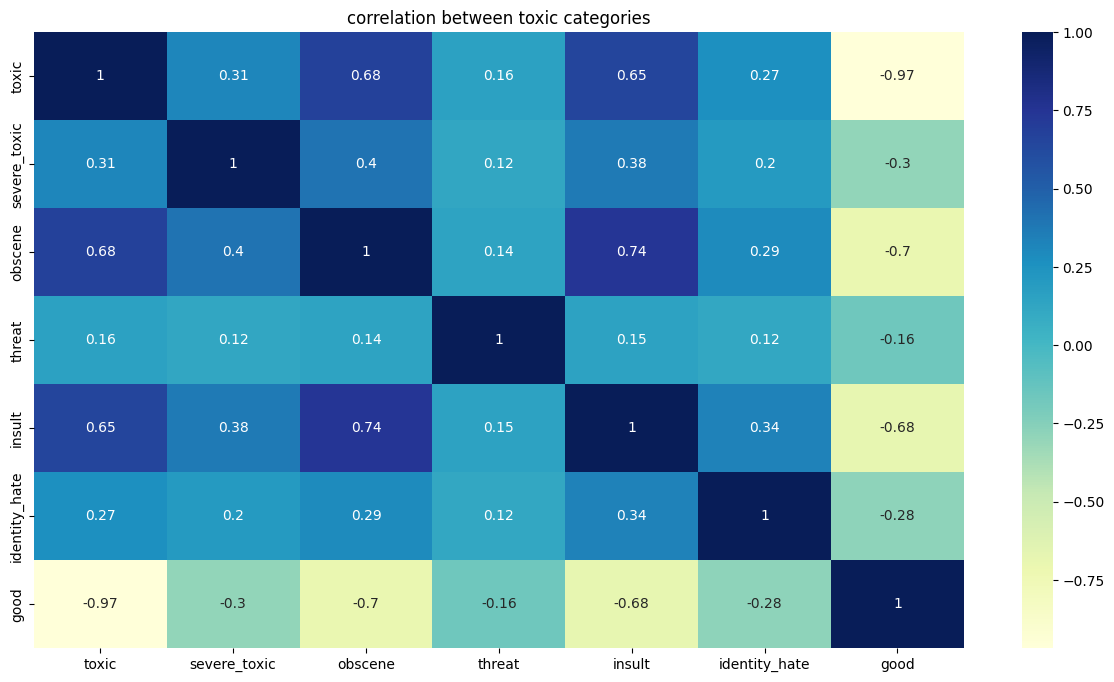

In [28]:
corr_between_labels(df)

CLearly it can be seen that Insult and Obscene, Toxic and obscene posses a strong correlation
 Most severe_toxic comments are also obscene in nature and 
toxic, insult and obscene comments share a good amount of overlap

In [46]:
# length analysis
def text_length_across_classes(df):
    median_text_len = []
    mean_text_len = []
    min_text_len = []
    max_text_len = []
    max_distinct_tokens = []
    
    for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','good']:
        mean_text_len.append(df[df[i]==1]['comment_length'].mean())  
        min_text_len.append(df[df[i]==1]['comment_length'].min())  
        max_text_len.append(df[df[i]==1]['comment_length'].max())  
        median_text_len.append(df[df[i]==1]['comment_length'].median())  

        df['distinct_tokens'] = df['comment_text'].apply(lambda x : len(set(x.split())))
        max_distinct_tokens.append(df[df[i]==1]['distinct_tokens'].max())
        
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))

    sns.barplot(ax=axes[0,0], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','good'], y=median_text_len)
    axes[0,0].set_title('median text length')

    sns.barplot(ax=axes[0,1], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','good'], y=min_text_len)
    axes[0,1].set_title('minimum text length')

    sns.barplot(ax=axes[1,0], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','good'], y=max_text_len)
    axes[1,0].set_title('max text length')

    sns.barplot(ax=axes[1,1], x=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','good'], y=max_distinct_tokens)
    axes[1,1].set_title('max distinct tokens')

    fig.suptitle('text length statistics')
    plt.show()
    
    return 

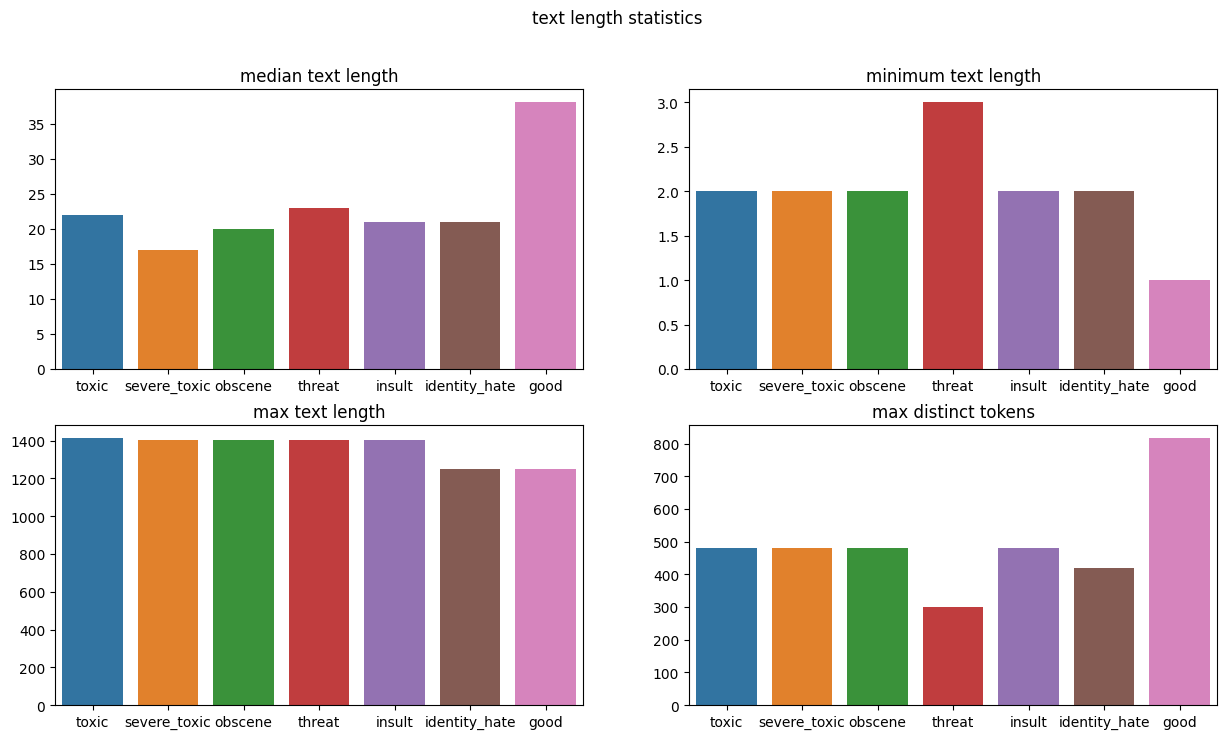

In [63]:
df['comment_length'] = df['comment_text'].apply(lambda x : len(x.split()))
text_length_across_classes(df)

The average word length in both clean and toxic comments is unreasobaly high.
May need to clean data.

In [54]:
# word cloud
def generate_wordclouds(df, text_col, categ_col):
    if categ_col=='all_toxic':
        category_text = df[df['good']!=1][text_col].values
    else:
        category_text = df[df[categ_col]==1][text_col].values
               
    plt.figure(figsize=(10,6))
    wc = WordCloud(background_color="black", 
                   max_words=5000, 
                   stopwords=STOPWORDS, 
                   collocations=False,
                   max_font_size= 40)
    
    wc.generate(" ".join(category_text))
    plt.title("{} word cloud".format(categ_col), fontsize=20)
    # plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
    plt.axis('off')
    
    plt.show()
    
    return 

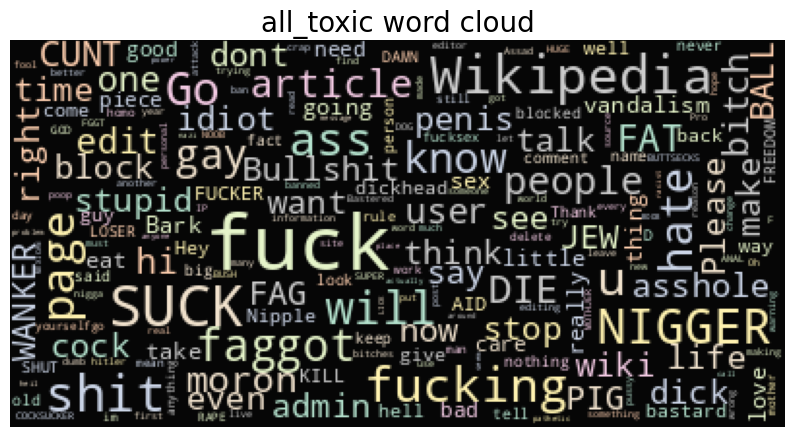

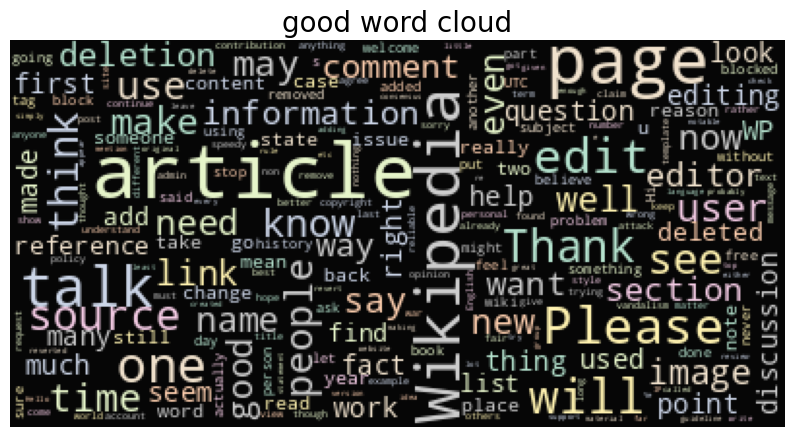

In [55]:
generate_wordclouds(df, 'comment_text', 'all_toxic')
generate_wordclouds(df, 'comment_text', 'good')

In [61]:
# intersection among the labels
def venn_(df):
    figure, axes = plt.subplots(2,2,figsize=(12,12))
    toxic = set(df[df['toxic']==1].index)
    severe_toxic = set(df[df['severe_toxic']==1].index)
    obscene = set(df[df['obscene']==1].index)
    threat = set(df[df['threat']==1].index)
    insult = set(df[df['insult']==1].index)
    identity_hate = set(df[df['identity_hate']==1].index)
    good = set(df[df['good']==1].index)

    v1 = venn3([toxic, severe_toxic, obscene], set_labels=('Toxic','Severe toxic','Obscene'), set_colors=('#a5e6ff', '#3c8492','#9D8189'), ax=axes[0][0])
    for text in v1.set_labels:
        text.set_fontsize(12)

    v2 = venn3([threat, insult, identity_hate],set_labels=('Threat','Insult','Identity hate'), set_colors=('#e196ce', '#F29CB7','#3c81a9'), ax=axes[0][1])
    for text in v2.set_labels:
        text.set_fontsize(12)

    v3 = venn3([toxic, insult, obscene],set_labels=('Toxic','Insult','Obscene'), set_colors=('#a5e6ff', '#F29CB7','#9D8189'), ax=axes[1][0])
    for text in v3.set_labels:
        text.set_fontsize(12)

    v4 = venn3([threat, identity_hate, obscene],set_labels=('Threat','Identity hate','Obscene'), set_colors=('#e196ce', '#3c81a9','#9D8189'), ax=axes[1][1])
    for text in v4.set_labels:
        text.set_fontsize(12)

    plt.show()
    
    # deleting used variables
    del toxic
    del severe_toxic
    del obscene
    del threat
    del insult
    del identity_hate
    del good
    
    return

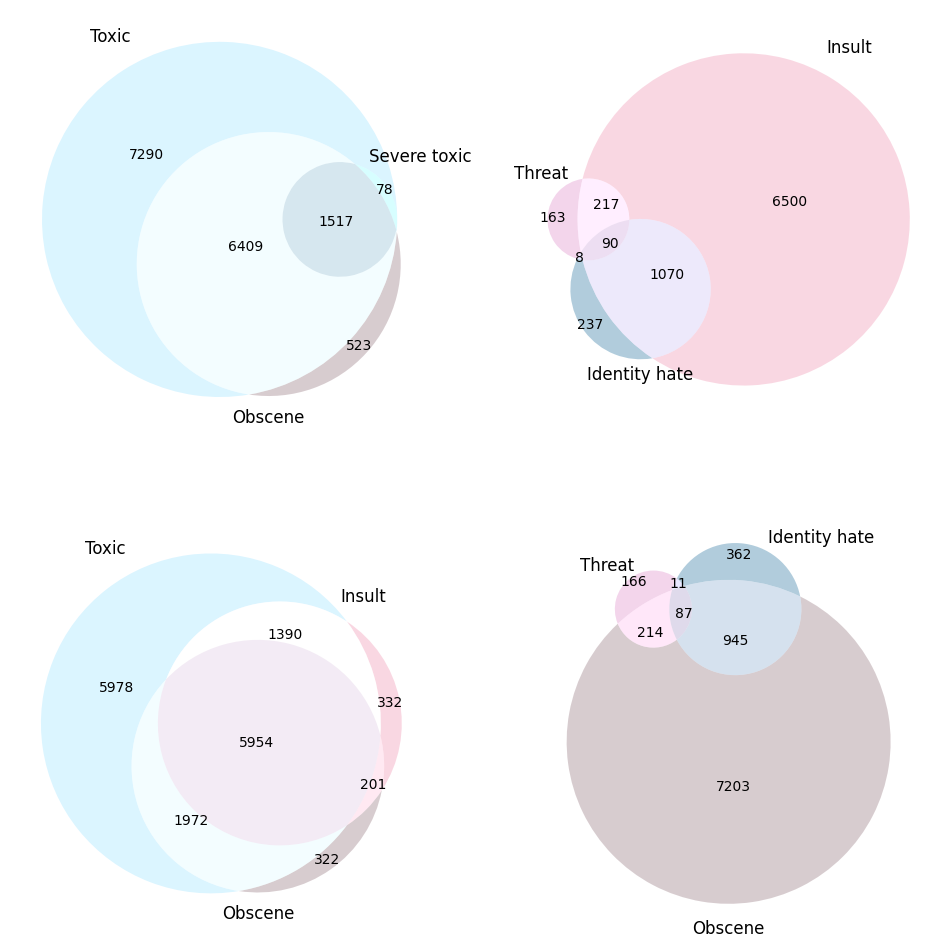

In [62]:
venn_(df)

In [ ]:
# finish EDA here

In [8]:
train_df, test_df = train_test_split(df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.1)

In [9]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,good
143178,fdbd26ddcd879334,"""\n The section """"#Dear Michael Bednarek"""" is ...",0,0,0,0,0,0,1
149819,61ff36165d88ff45,This is my account and not a puppet one. Pleas...,0,0,0,0,0,0,1
54416,9168da19376537b3,Prayer of The Heart\n\nHave made an edit to th...,0,0,0,0,0,0,1
78060,d0f6c861bd3a0fd4,natioanl football team |Cambodia]],0,0,0,0,0,0,1
136185,d88472ac6a01c85d,"""\n\n """"High Five"""" in Railway Conductor book ...",0,0,0,0,0,0,1


In [10]:
train_df['comment_text'][80]

'"\n\nMinimization of textile effluent\n\nA proposed deletion template has been added to the article Minimization of textile effluent, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but this article may not satisfy Wikipedia\'s criteria for inclusion, and the deletion notice should explain why (see also ""What Wikipedia is not"" and Wikipedia\'s deletion policy).  You may prevent the proposed deletion by removing the  notice, but please explain why you disagree with the proposed deletion in your edit summary or on its talk page. Also, please consider improving the article to address the issues raised. Even though removing the deletion notice will prevent deletion through the proposed deletion process, the article may still be deleted if it matches any of the speedy deletion criteria or it can be sent to Articles for Deletion, where it may be deleted if consensus to delete is reached. If you agree with the deletion of the art

<Axes: >

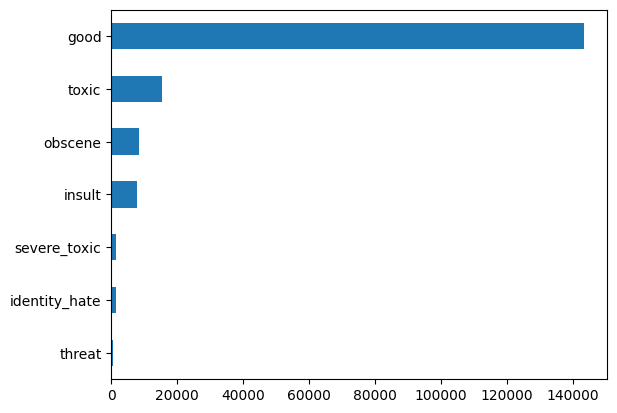

In [11]:
# overall data
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")

<Axes: >

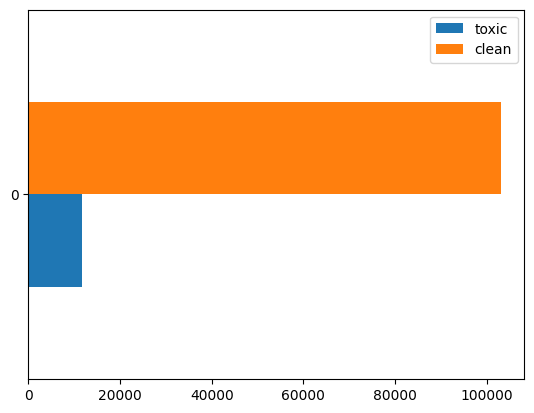

In [12]:
train_toxic = train_df[train_df['good'] == 0]
train_clean = train_df[train_df['good'] == 1]

pd.DataFrame(dict(toxic=[len(train_toxic)], clean=[len(train_clean)])).plot(kind='barh')

In [ ]:
train_df = pd.concat([train_toxic, train_clean.sample(15_000)])

<Axes: >

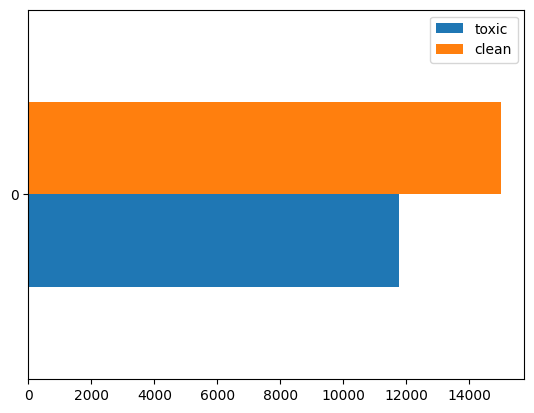

In [ ]:
train_toxic = train_df[train_df['good'] == 0]
train_clean = train_df[train_df['good'] == 1]

pd.DataFrame(dict(toxic=[len(train_toxic)], clean=[len(train_clean)])).plot(kind='barh')

In [ ]:
print(train_df.shape, val_df.shape, test_df.shape)

(26780, 9) (12766, 9) (31915, 9)


In [ ]:
def data_preprocessing(sentences):

    tokenized_sentences = []
    for sentence in tqdm(sentences, desc = 'Tokenize'):
        sentence = sentence.lower()
        cleanr = re.compile('<.*?>')
        sentence = re.sub(cleanr, ' ', sentence)

        sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)
        sentence = sentence.strip()
        sentence = sentence.replace("\n"," ")
        sentence = re.sub(r'[^A-Za-z ]', '', sentence)
        sentence = re.sub('\s+', ' ', sentence)

        tokenized_sentences.append(nltk.word_tokenize(sentence))

    stop_words = set(stopwords.words('english'))

    removed_stop_words = []
    for sentence in tqdm(tokenized_sentences, desc = 'Stop_word_removal'):
        curr_sentence = []
        for token in sentence:
            if not token in stop_words:
                curr_sentence.append(token)
        
        removed_stop_words.append(curr_sentence)

    lemmatizer = WordNetLemmatizer()

    lemmatized_sentence = []
    for sentence in tqdm(removed_stop_words, desc = 'Lemmatization'):
        curr_sentence = []
        for token in sentence:
            curr_sentence.append(lemmatizer.lemmatize(token))

        lemmatized_sentence.append(curr_sentence)

    return lemmatized_sentence

In [ ]:
def vocab_builder(sentences):
    # Word dictionary
    word_vocab = {}
    unique_id = 1
    for sentence in sentences:
        for word in sentence:
            if word not in word_vocab:
                word_vocab[word] = unique_id
                unique_id += 1

    word_vocab['<PAD>'] = 0
    word_vocab['<OOV>'] = unique_id

    return word_vocab

In [ ]:
def text_to_sequence(sentences, word_vocab):

    text_sequece = []
    for sentence in sentences:
        curr_sequence = []
        for word in sentence:
            if word in word_vocab:
                curr_sequence.append(word_vocab[word])
            else:
                curr_sequence.append(word_vocab['<OOV>'])
        text_sequece.append(curr_sequence)

    return text_sequece

def pad_sequences(seq, maxlen):
    padded_seq = []
    if len(seq) < maxlen:
        padding_seq = [0] * (maxlen - len(seq))
        padded_seq = padding_seq + seq
    else:
        padded_seq = seq
        
    return padded_seq


def padding(sequence, max_length):
    new_sequence = []
    for i in range(len(sequence)):
        if len(sequence[i]) <= max_length:
            new_sequence.append(sequence[i])
        else:
            new_sequence.append(sequence[i][:max_length])
            

    sequence = new_sequence

    X = []
    for seq in tqdm(sequence, desc = 'Padding'):
        X.append(pad_sequences(seq, maxlen = max_length))

    return X

In [ ]:
max_length = 200

In [ ]:
# Train data
train_sentences = train_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
train_labels = train_df[cols].values

train_sentences = data_preprocessing(train_sentences)
word_vocab = vocab_builder(train_sentences)
vocab_size = len(word_vocab)
train_sequence = text_to_sequence(train_sentences, word_vocab)
train_sequence = padding(train_sequence, max_length)

X_train = np.array(train_sequence)
y_train = np.array(train_labels)

Padding: 100%|██████████| 26780/26780 [00:00<00:00, 59038.00it/s]


In [ ]:
# Val data
val_sentences = val_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
val_labels = val_df[cols].values

val_sentences = data_preprocessing(val_sentences)
val_sequence = text_to_sequence(val_sentences, word_vocab)
val_sequence = padding(val_sequence, max_length)

X_val = np.array(val_sequence)
y_val = np.array(val_labels)

Padding: 100%|██████████| 12766/12766 [00:00<00:00, 241576.59it/s]


In [ ]:
# Test data
test_sentences = test_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
test_labels = test_df[cols].values

test_sentences = data_preprocessing(test_sentences)
test_sequence = text_to_sequence(test_sentences, word_vocab)
test_sequence = padding(test_sequence, max_length)

X_test = np.array(test_sequence)
y_test = np.array(test_labels)

Padding: 100%|██████████| 31915/31915 [00:00<00:00, 217621.94it/s]


In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(26780, 200) (26780, 7)
(12766, 200) (12766, 7)
(31915, 200) (31915, 7)


In [ ]:
print(vocab_size, max_length)

57902 200


In [ ]:
# save word2idx, maxlength
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word_vocab, f)

with open('maxlength.pkl', 'wb') as f:
    pickle.dump(max_length, f)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sequence, labels):
        self.sequence = sequence
        self.labels = labels

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        sequence_in = torch.tensor(self.sequence[idx])
        output_label = torch.tensor(self.labels[idx]).float()
        return sequence_in, output_label

In [ ]:
batch_size = 64

dataset_train = CustomDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = CustomDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = CustomDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
def load_embeddings(embeddings_file):
    embeddings_index = {}
    with open(embeddings_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_file = '/content/drive/MyDrive/glove.6B.300d.txt'
embeddings_index = load_embeddings(embeddings_file)

In [ ]:
embeddings_dim = 300
pretrained_embeddings = []

for word in word_vocab:
    if word in embeddings_index:
        pretrained_embeddings.append(embeddings_index.get(word))
    else:
        pretrained_embeddings.append([0] * embeddings_dim)

pretrained_embeddings = torch.Tensor(pretrained_embeddings)

<ipython-input-26-c2cf0cd7e6ae>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  pretrained_embeddings = torch.Tensor(pretrained_embeddings)


In [ ]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, slope):
        super(GraphAttentionLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(out_features * 2, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(slope)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, h, adj):
        Wh = self.W(h)
        num_nodes = Wh.size(0)
        Whi = Wh.repeat_interleave(num_nodes, dim=0)
        Whj = Wh.repeat(num_nodes, 1)
        WhiWhj = torch.cat([Whi, Whj], dim=1)
        Whcat = WhiWhj.view(num_nodes, num_nodes, Wh.size(1) * 2)
        e = self.leakyrelu(self.a(Whcat).squeeze(2))
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = self.softmax(attention)
        h_hat = torch.mm(attention, Wh)
        return h_hat


class MAGNET(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        adjacency_matrix,
        node_embeddings,
        num_heads=4,
        slope=0.01,
        dropout=0.5,
    ):

        super(MAGNET, self).__init__()

        self.node_embedding = nn.Embedding.from_pretrained(node_embeddings)

        self.rnn = nn.LSTM(
            input_size, hidden_size, batch_first=True, bidirectional=True
        )

        self.attentions1 = nn.ModuleList(
            [
                GraphAttentionLayer(input_size, hidden_size * 2, slope)
                for _ in range(num_heads)
            ]
        )

        self.tanh1 = nn.Tanh()

        self.attentions2 = nn.ModuleList(
            [
                GraphAttentionLayer(hidden_size * 2, hidden_size * 2, slope)
                for _ in range(num_heads)
            ]
        )

        self.tanh2 = nn.Tanh()

        self.adjacency_matrix = nn.Parameter(adjacency_matrix)

        self.dropout = nn.Dropout(dropout)

    def forward(self, tokens, label_embedding):

        node_features = self.node_embedding(tokens).float()

        lstm_output, (hidden, _) = self.rnn(node_features)

        hidden_state = torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)

        hidden_state = self.dropout(hidden_state)

        heads_out1 = [
            att(label_embedding, self.adjacency_matrix) for att in self.attentions1
        ]

        head_out1_mean = self.tanh1(torch.stack(heads_out1, dim=0).mean(0))

        heads_out2 = [
            att(head_out1_mean, self.adjacency_matrix) for att in self.attentions2
        ]

        head_out2_mean = self.tanh2(torch.stack(heads_out2, dim=0).mean(0))

        attention = self.dropout(head_out2_mean)

        attention = attention.transpose(0, 1)

        output = torch.mm(hidden_state, attention)

        return output

In [ ]:
def train_model(model, label_embedding, loss_function, optimizer, epochs, device):

    train_loss, val_loss = [], []
    total_time = 0
    min_average_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()

        print("Epoch : ", epoch + 1)

        model.to(device)
        model.train()
        total_train_loss = 0
        for batch in tqdm(dataloader_train, desc='Training'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            model.zero_grad()
            pred_batch = model(sequence_in, label_embedding)
            loss = loss_function(pred_batch, output_label)
            total_train_loss += loss.item()

            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
        
        model.eval()    

        y_true_train, y_pred_train = [], []
        with torch.no_grad() :
            for batch in tqdm(dataloader_train, desc='Evaluate'):
                sequence_in, output_label = batch
                sequence_in, output_label = sequence_in.to(device), output_label.to(device)

                pred_batch = model(sequence_in, label_embedding)
                
                y_true_train.extend(output_label.cpu().detach().numpy().tolist())
                y_pred_train.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())

        total_val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for batch in tqdm(dataloader_val, desc='Evaluate'):
                sequence_in, output_label = batch
                sequence_in, output_label = sequence_in.to(device), output_label.to(device)

                pred_batch = model(sequence_in, label_embedding)
                loss = loss_function(pred_batch, output_label)
                total_val_loss += loss.item()

                y_true_val.extend(output_label.cpu().detach().numpy().tolist())
                y_pred_val.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())

        y_true_train = np.array(y_true_train)
        y_pred_train = np.array(y_pred_train)
        y_true_val = np.array(y_true_val)
        y_pred_val = np.array(y_pred_val)

        y_pred_train = y_pred_train >= 0.5
        y_pred_val = y_pred_val >= 0.5

        train_f1_score_micro = metrics.f1_score(y_true_train, y_pred_train, average='micro')
        val_f1_score_micro = metrics.f1_score(y_true_val, y_pred_val, average='micro')

        average_train_loss = float(total_train_loss / len(dataloader_train))
        average_val_loss = float(total_val_loss / len(dataloader_val))

        print('Train F1 Score (Micro)', train_f1_score_micro)
        print('Val F1 Score (Micro)', val_f1_score_micro)
        print('Train loss', average_train_loss)
        print('Val loss', average_val_loss)

        train_loss.append(average_train_loss)
        val_loss.append(average_val_loss)

        if average_val_loss < min_average_loss:
            min_average_loss = average_val_loss
            torch.save(model, 'model.pth')
            print("Best model saved")
            
        print("------------------------------------------------")

        end_time = time.time()
        epoch_time = end_time - start_time
        total_time += epoch_time

    avg_epoch_time = total_time / epochs
    return train_loss, val_loss, avg_epoch_time

In [ ]:
def buildAdjacencyCOOC(data_label):
  adj = data_label.T.dot(data_label).astype('float')
  for i in range(len(adj)):
    adj[i] = adj[i] / adj[i,i]
  
  return torch.from_numpy(adj.astype('float32'))

In [ ]:
adjacency = buildAdjacencyCOOC(y_train)

In [ ]:
label_embedding = torch.zeros(7, 300)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']

for index, label in enumerate(labels):
  words = label.split('_')
  num_of_words = len(words)
  
  for sublabel in words:
    if sublabel in embeddings_index.keys():
      label_embedding[index] +=  torch.from_numpy(embeddings_index[sublabel])
  label_embedding[index] = label_embedding[index]/num_of_words

label_embedding = label_embedding.float().to(device)
print(label_embedding, label_embedding.shape)

tensor([[-0.1338,  0.4449, -0.1320,  ..., -0.3913, -0.4084,  0.0045],
        [-0.1352,  0.1137, -0.3520,  ..., -0.1768,  0.1053, -0.3155],
        [-0.3243,  0.0416,  0.2132,  ...,  0.1782,  0.2137, -1.1418],
        ...,
        [-0.0302,  0.2444,  0.0910,  ...,  0.2767, -0.0892, -0.3096],
        [-0.1872, -0.1358, -0.0330,  ...,  0.4099, -0.0587,  0.1831],
        [-0.1360, -0.1159, -0.0171,  ..., -0.3376,  0.0701,  0.2464]],
       device='cuda:0') torch.Size([7, 300])


In [ ]:
epochs = 30
learning_rate = 0.001

magnet_model = MAGNET(300, 250, adjacency.to(device), pretrained_embeddings.to(device))
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model.parameters(), lr = learning_rate)
train_loss, val_loss, avg_epoch_time = train_model(magnet_model, label_embedding, loss_function, optimizer, epochs, device)

Epoch :  1


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 64.45it/s]


Train F1 Score (Micro) 0.44861258474652477
Val F1 Score (Micro) 0.7824488090263267
Train loss 0.4077380956072796
Val loss 0.18677269943058492
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 61.30it/s]


Train F1 Score (Micro) 0.6174142480211082
Val F1 Score (Micro) 0.8620093440753411
Train loss 0.3647038439079799
Val loss 0.12592408481985332
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 55.53it/s]


Train F1 Score (Micro) 0.5334972341733252
Val F1 Score (Micro) 0.8446052217678514
Train loss 0.3433476793168553
Val loss 0.128821592759341
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 60.34it/s]


Train F1 Score (Micro) 0.6262021258646869
Val F1 Score (Micro) 0.8349848873244825
Train loss 0.3294564892042224
Val loss 0.14692352276295423
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.85it/s]


Train F1 Score (Micro) 0.6383397588384874
Val F1 Score (Micro) 0.8583710238104139
Train loss 0.3357179761644195
Val loss 0.12136931089684368
Best model saved
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.80it/s]


Train F1 Score (Micro) 0.594951812758146
Val F1 Score (Micro) 0.8654315340042695
Train loss 0.3121562194354779
Val loss 0.10572644522413611
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 55.08it/s]


Train F1 Score (Micro) 0.6500316725880636
Val F1 Score (Micro) 0.8652392947103275
Train loss 0.30418849251008545
Val loss 0.11412319242954254
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.74it/s]


Train F1 Score (Micro) 0.6399736412342778
Val F1 Score (Micro) 0.8658627920910724
Train loss 0.29574412648034837
Val loss 0.10969486698508263
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 59.56it/s]


Train F1 Score (Micro) 0.6094747966732528
Val F1 Score (Micro) 0.8627390971690896
Train loss 0.2932861151089247
Val loss 0.1073582347529009
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 49.31it/s]


Train F1 Score (Micro) 0.6613466609600863
Val F1 Score (Micro) 0.8363802212002585
Train loss 0.2850236014278521
Val loss 0.13357709165662526
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 60.32it/s]


Train F1 Score (Micro) 0.6348169080419169
Val F1 Score (Micro) 0.8200548374461418
Train loss 0.28245720462895807
Val loss 0.14092428531497717
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 40.82it/s]


Train F1 Score (Micro) 0.6773879654954765
Val F1 Score (Micro) 0.869920478587583
Train loss 0.27516565911098423
Val loss 0.11479297729209065
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 59.95it/s]


Train F1 Score (Micro) 0.6680766869072798
Val F1 Score (Micro) 0.8650966764020851
Train loss 0.27804419384082346
Val loss 0.11486967168748378
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 56.20it/s]


Train F1 Score (Micro) 0.6040974977730991
Val F1 Score (Micro) 0.8421094119501813
Train loss 0.27087372434736723
Val loss 0.12580963715910912
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 58.59it/s]


Train F1 Score (Micro) 0.5986112245731559
Val F1 Score (Micro) 0.8033236461872211
Train loss 0.26446121909737874
Val loss 0.14970113698393106
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.42it/s]


Train F1 Score (Micro) 0.6430156549568997
Val F1 Score (Micro) 0.8378810945856268
Train loss 0.26209962823225946
Val loss 0.13632918864488602
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 63.00it/s]


Train F1 Score (Micro) 0.7043992606284658
Val F1 Score (Micro) 0.8502446982055466
Train loss 0.25806216483042177
Val loss 0.13272123566828667
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.63it/s]


Train F1 Score (Micro) 0.643610803261018
Val F1 Score (Micro) 0.8462968701580416
Train loss 0.25860939439839564
Val loss 0.13481026051566006
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.45it/s]


Train F1 Score (Micro) 0.6859682779864357
Val F1 Score (Micro) 0.8594961599821912
Train loss 0.2531957525697699
Val loss 0.12862443301826715
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 58.64it/s]


Train F1 Score (Micro) 0.654875646210135
Val F1 Score (Micro) 0.8497985804718973
Train loss 0.2527162479614586
Val loss 0.13200756257399918
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 55.57it/s]


Train F1 Score (Micro) 0.6856725344013422
Val F1 Score (Micro) 0.8472227452457165
Train loss 0.25143882959440955
Val loss 0.141374614238739
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 61.59it/s]


Train F1 Score (Micro) 0.6665913475744356
Val F1 Score (Micro) 0.7576510552637372
Train loss 0.24616354266470541
Val loss 0.21859453916549682
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 54.83it/s]


Train F1 Score (Micro) 0.793556055739612
Val F1 Score (Micro) 0.8669439434649785
Train loss 0.21876832958408643
Val loss 0.13334333784878255
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.79it/s]


Train F1 Score (Micro) 0.7961470462720233
Val F1 Score (Micro) 0.8699289603692618
Train loss 0.20361821620162746
Val loss 0.1252000025101006
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.51it/s]


Train F1 Score (Micro) 0.7332115390281994
Val F1 Score (Micro) 0.8676908965833525
Train loss 0.2344894461991679
Val loss 0.13407238360494375
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 59.29it/s]


Train F1 Score (Micro) 0.7998599982499781
Val F1 Score (Micro) 0.8649640393365624
Train loss 0.22900257796618137
Val loss 0.14383735332638026
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 55.58it/s]


Train F1 Score (Micro) 0.7993749478129137
Val F1 Score (Micro) 0.8545140885566417
Train loss 0.19857262423470937
Val loss 0.14034607395529747
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 59.66it/s]


Train F1 Score (Micro) 0.8019406125789106
Val F1 Score (Micro) 0.8494723996841577
Train loss 0.19243391012875163
Val loss 0.15368100916966795
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.19it/s]


Train F1 Score (Micro) 0.7141415398227643
Val F1 Score (Micro) 0.8518504488806393
Train loss 0.195328127886202
Val loss 0.14295793179422617
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.83it/s]


Train F1 Score (Micro) 0.7479457654834094
Val F1 Score (Micro) 0.851945312794245
Train loss 0.22323090563526016
Val loss 0.15534578191116452
------------------------------------------------


In [ ]:
with open('label_embedding.pkl', 'wb') as f:
    pickle.dump(label_embedding, f)

# Evaluation

In [ ]:
def test_scores(model, device, label_embedding):

    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader_test, desc='Evaluate'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            pred_batch = model(sequence_in, label_embedding)

            y_true.extend(output_label.cpu().detach().numpy().tolist())
            y_pred.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_pred = y_pred >= 0.5

    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1_score_micro = metrics.f1_score(y_true, y_pred, average='micro')

    print('Test Accuracy', accuracy)
    print('Test F1 Score (Micro)', f1_score_micro)

    print('Classification report')
    print(classification_report(y_true, y_pred, zero_division=0, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate', 'good']))

In [ ]:
model = torch.load('model.pth')
test_scores(model, device, label_embedding)

Evaluate: 100%|██████████| 499/499 [00:08<00:00, 56.70it/s]


Test Accuracy 0.8482218392605358
Test F1 Score (Micro) 0.8631572515352419
Classification report
               precision    recall  f1-score   support

        toxic       0.99      0.12      0.21      3002
 severe_toxic       0.31      0.37      0.34       297
      obscene       0.92      0.21      0.34      1612
       threat       0.05      0.20      0.08        91
       insult       0.83      0.20      0.32      1495
identity_hate       0.19      0.25      0.22       277
         good       0.97      0.94      0.96     28733

    micro avg       0.94      0.80      0.86     35507
    macro avg       0.61      0.33      0.35     35507
 weighted avg       0.95      0.80      0.83     35507
  samples avg       0.85      0.86      0.86     35507



In [ ]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad) 

print(model)
print(f'The model has {num_params:,} trainable parameters')

MAGNET(
  (node_embedding): Embedding(57902, 300)
  (rnn): LSTM(300, 250, batch_first=True, bidirectional=True)
  (attentions1): ModuleList(
    (0-3): 4 x GraphAttentionLayer(
      (W): Linear(in_features=300, out_features=500, bias=False)
      (a): Linear(in_features=1000, out_features=1, bias=False)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (softmax): Softmax(dim=1)
    )
  )
  (tanh1): Tanh()
  (attentions2): ModuleList(
    (0-3): 4 x GraphAttentionLayer(
      (W): Linear(in_features=500, out_features=500, bias=False)
      (a): Linear(in_features=1000, out_features=1, bias=False)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (softmax): Softmax(dim=1)
    )
  )
  (tanh2): Tanh()
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 2,712,049 trainable parameters


In [ ]:
print('Train loss', train_loss)
print('Val loss', val_loss)

Train loss [0.4077380956072796, 0.3647038439079799, 0.3433476793168553, 0.3294564892042224, 0.3357179761644195, 0.3121562194354779, 0.30418849251008545, 0.29574412648034837, 0.2932861151089247, 0.2850236014278521, 0.28245720462895807, 0.27516565911098423, 0.27804419384082346, 0.27087372434736723, 0.26446121909737874, 0.26209962823225946, 0.25806216483042177, 0.25860939439839564, 0.2531957525697699, 0.2527162479614586, 0.25143882959440955, 0.24616354266470541, 0.21876832958408643, 0.20361821620162746, 0.2344894461991679, 0.22900257796618137, 0.19857262423470937, 0.19243391012875163, 0.195328127886202, 0.22323090563526016]
Val loss [0.18677269943058492, 0.12592408481985332, 0.128821592759341, 0.14692352276295423, 0.12136931089684368, 0.10572644522413611, 0.11412319242954254, 0.10969486698508263, 0.1073582347529009, 0.13357709165662526, 0.14092428531497717, 0.11479297729209065, 0.11486967168748378, 0.12580963715910912, 0.14970113698393106, 0.13632918864488602, 0.13272123566828667, 0.13481

In [ ]:
print('Avg epoch time', round(avg_epoch_time, 2), 'secs')

Avg epoch time 29.14 secs
